<a href="https://colab.research.google.com/github/NickPavlovskii/sber/blob/main/sber_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Привожу ссылки, где вносились изменения: \
[Изменении 1](#section_ch_0) \
[Изменение 2](#section_ch_1) \
[Изменение 3](#section_ch_2) \
[Изменение 4](#section_ch_last) \

# <center> <font color='green'> Virtual internship Data Science in Sberbank</center> 
 
<img src = "https://avatars.mds.yandex.net/i?id=fe571f0aae6550a77d761e1c53476f39-5190933-images-thumbs&n=13" width = 900 height = 300/>


В файле data_1.csv представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1, то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

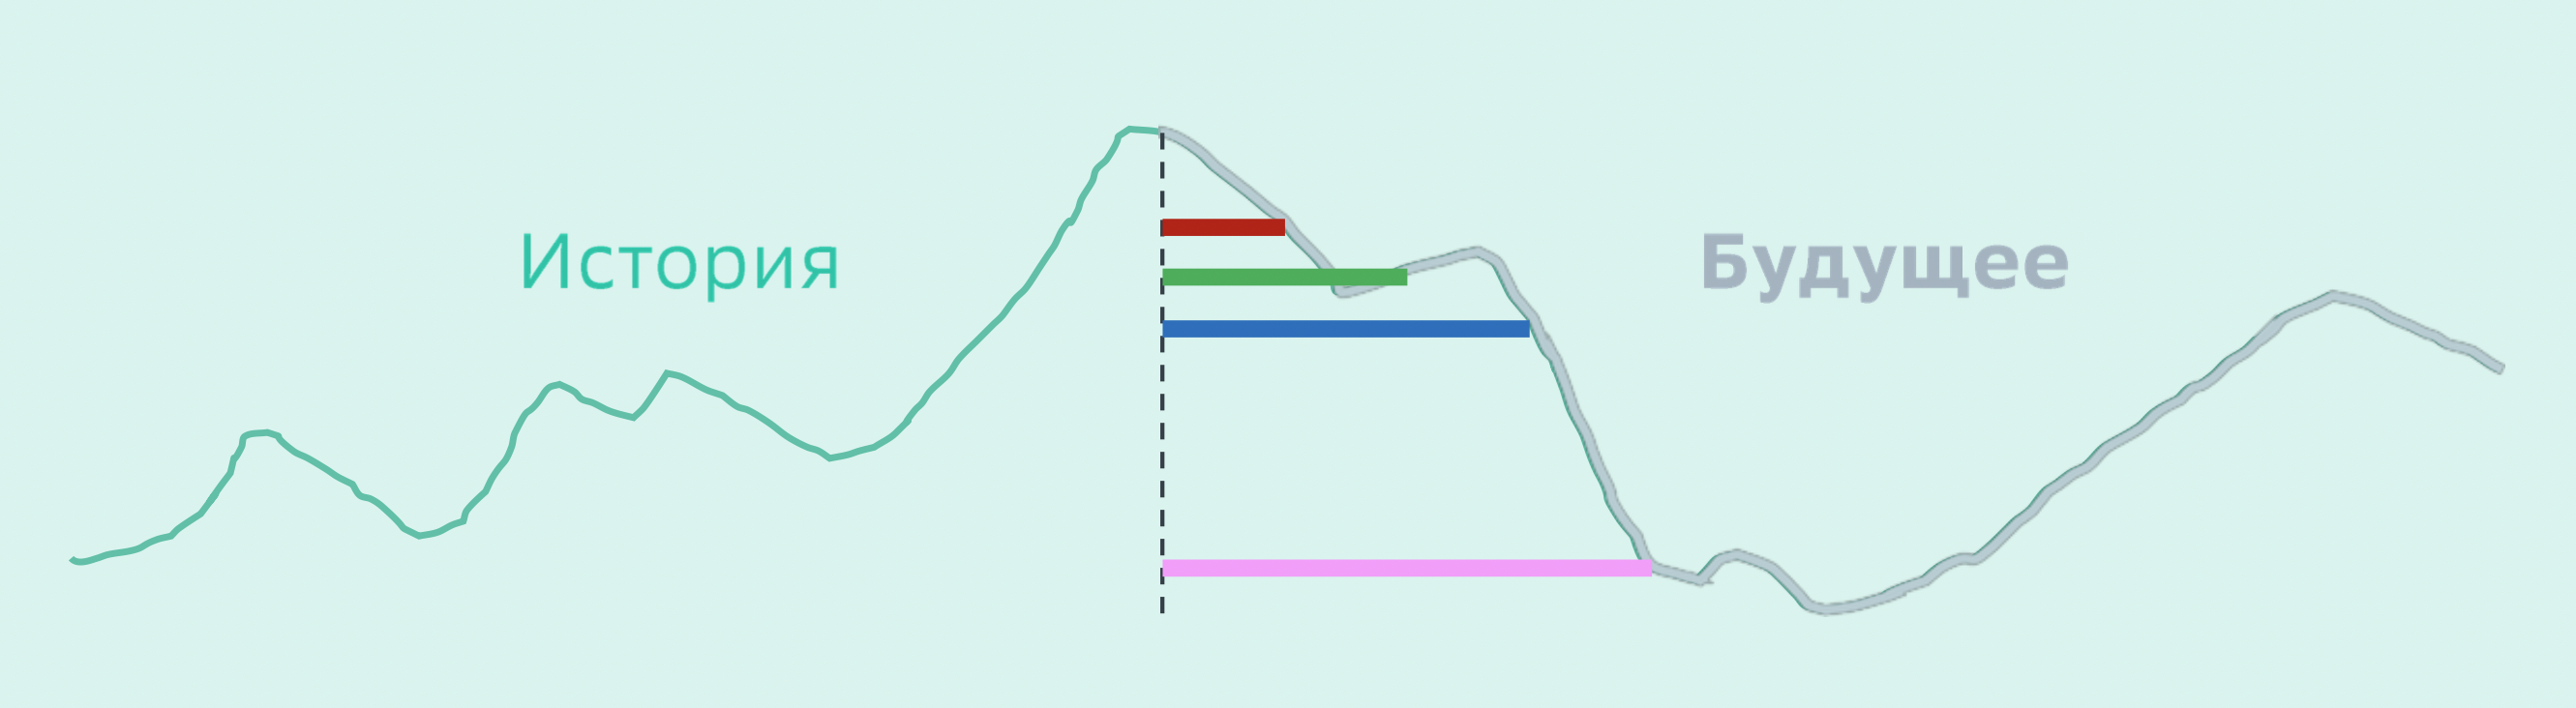

Задача: необходимо построить модель, которая оценивает обьем стабильной части средств на дату.


-  сделать прогноз объема расчетных счетов физических лиц на 1М, 2М, 3М...или др, 
- далее расчитывать минимальное значение объема `value` за данный промежуток. 

То есть после того, как сделал прогноз на промежуток 1 месяц, необходимо определить значение, ниже которого не опускается объема расчетных счетов физических лиц. 




 Оглавление :\
[1. Подготовка данных](#step_0) \
[2. Минимумв месяц(базовое решение)](#step_3) \
[3.Arima ](#Arima )\
[4. SARIMA](#step_2) \
[5. Skforecast](#step_4) \
[6. Обогатим данные](#step_5) \
[7. Лин регрессия](#step_6) \
[8. Лин регрессия 2 (удучшенная версия)](#step_7) \
[9. xgboost](#step_7) \
[10. Решение Сбера](#step_8)





---






<a id="title-one"></a>
<h1 style='background:#3CB371; border:2; border-radius: 10px; color:black'>
<center>Importing Libraries and Loading Data</center></h1>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# для исследования сезонности, тренда в данных
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn import metrics

from pylab import rcParams

# для теста на стационарность
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.stattools import jarque_bera 

import warnings
import itertools


from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import xgboost as xgb
import statsmodels.api as sm

# для форматирования графиков
%matplotlib inline
plt.rcParams.update({'font.size': 15, 
                     'figure.figsize': (18, 8), 
                     'axes.grid' : True})

<a id='step_0'></a>
# Подготовка данных

In [17]:
columns=['Date', 'value']

dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dataset.dropna(subset=['value'], how='all')

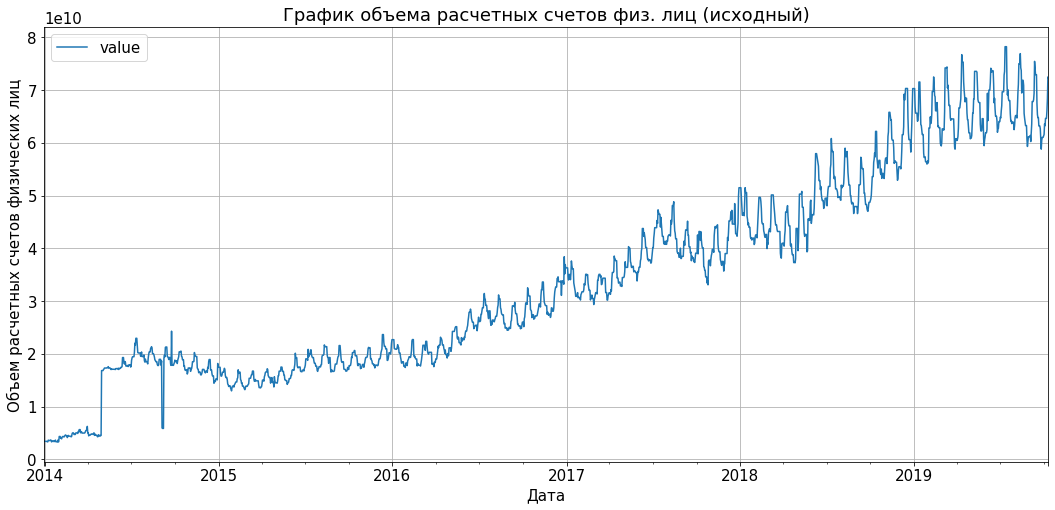

In [18]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц (исходный)')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Проанализировав этот график, можно сделать несколько выводов:

Баланс счета увеличивается к середине месяца, затем падает в течение 10-15 дней и снова начинает расти.
В некоторых точках графика наблюдается небольшое проседание ниже уровня предыдущего пика.
Общая тенденция направлена на увеличение, то есть временной ряд не является стационарным, поскольку его математическое ожидание растет со временем.

Попробуем избавиться от выброса во второй половине 2014 года

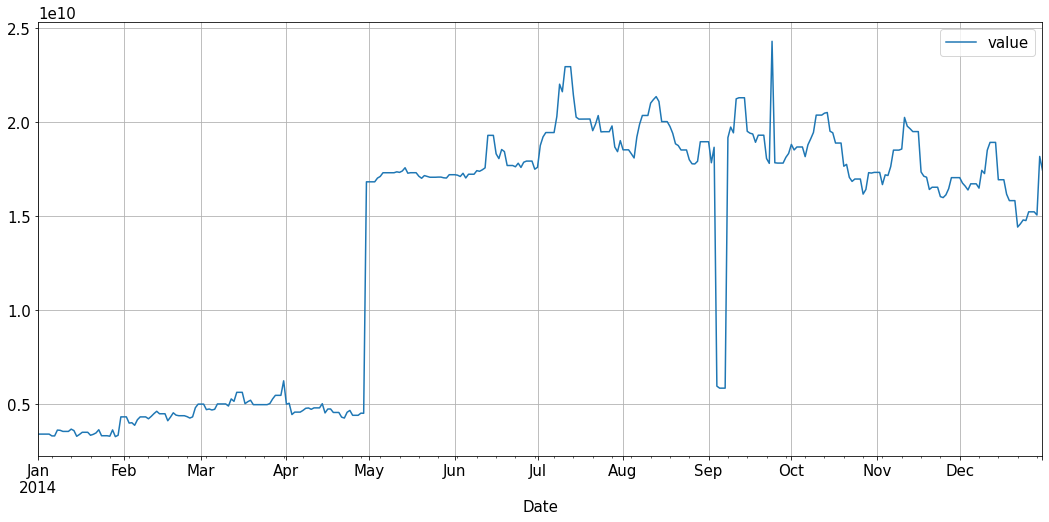

In [19]:
dataset.loc['2014'].plot(y='value');

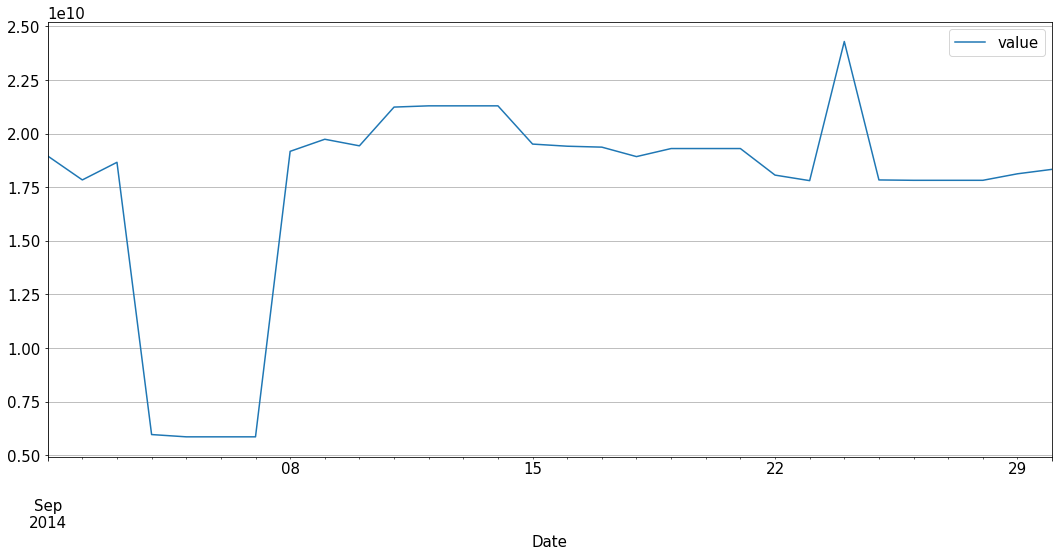

In [20]:
dataset.loc['2014-09'].plot(y='value');

C 04 сентября по 07 сентября 2014 года наблюдается резкий спад объема счетов физ. лиц. Предполагаемой причиной такого резкого спада могло стать подорожание евра,а так же понижения процентов на вкладах. В предполагаемой модели данный фактор не будет учтен, поэтому пока можно удалить данный выброс.

In [21]:
dataset = dataset.drop(['2014-09-04','2014-09-05','2014-09-06','2014-09-07'])


# dataset=dataset.drop(['2014-09-02','2014-09-03','2014-09-04','2014-09-05','2014-09-06','2014-09-07','2014-09-23','2014-09-24','2014-09-25'])


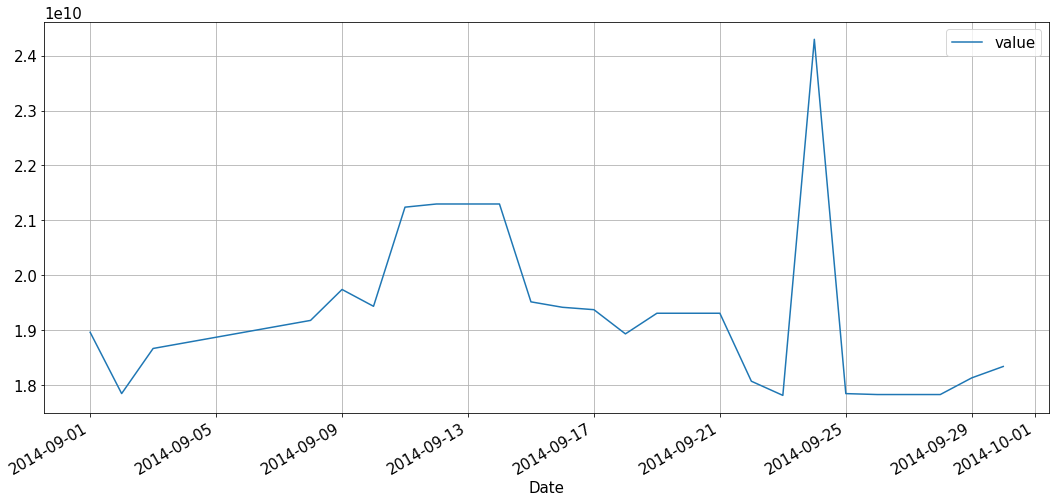

In [22]:
dataset.loc['2014-09'].plot(y='value');

In [23]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2107 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2107 non-null   int64
dtypes: int64(1)
memory usage: 32.9 KB


Пропущенных значений нет

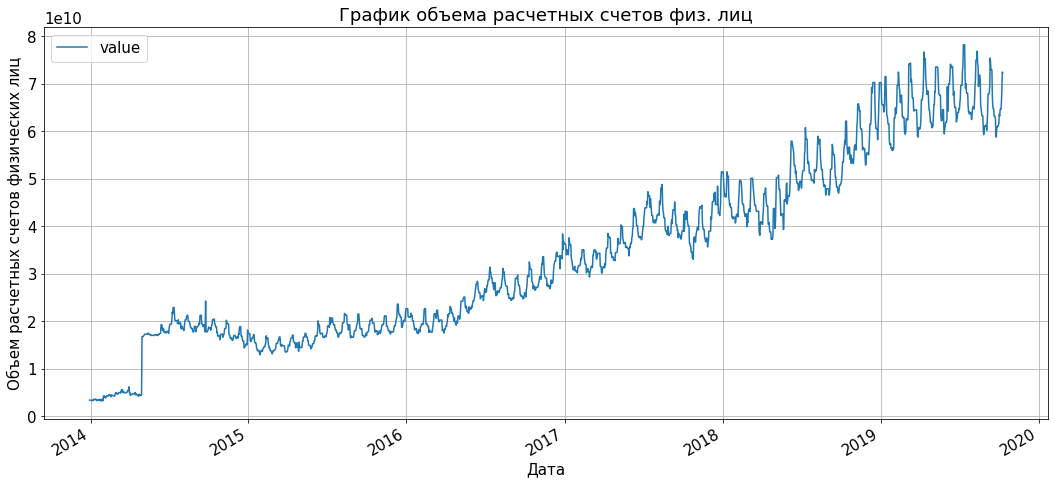

In [24]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

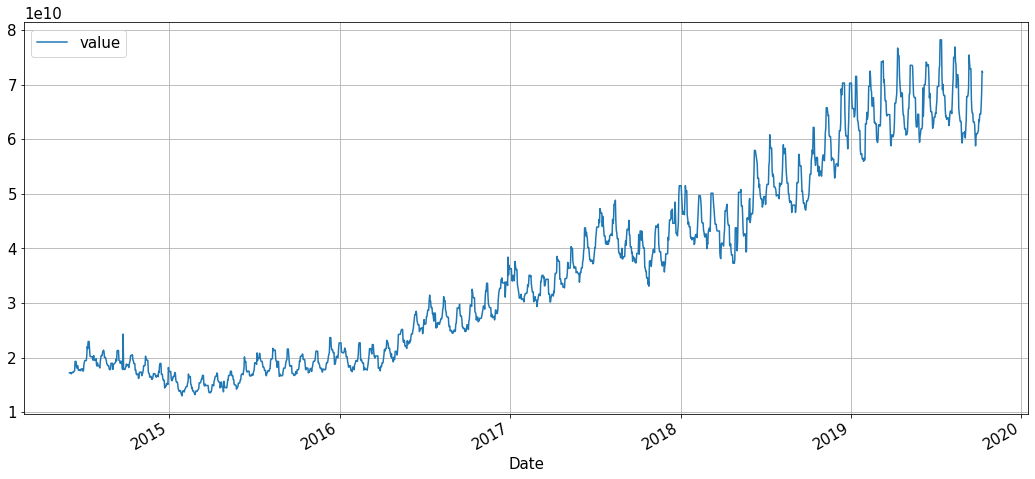

In [25]:
dataset=dataset['2014-06':]
dataset.plot(y='value')

Когда мы создаем прогнозирующую для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой ковариацией, поэтому проведем проверку нашего ряда на стационарность с помощью теста Дики-Фуллера.

- H0 гипотеза: ряд не стационарен 
- H1 гипотеза: ряд стационарен


In [26]:
# Определяем функцию для теста ADF
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(dataset)

Results of Dickey-Fuller Test:
Test Statistic                    0.905860
p-value                           0.993166
Lags Used                        26.000000
Number of Observations Used    1927.000000
Critical Value (1%)              -3.433748
Critical Value (5%)              -2.863041
Critical Value (10%)             -2.567569
dtype: float64


$p_{value} = 0.991880, p_{value} > 0.05$ => p-значение для временного ряда больше 5%, следовательно не удалось опровергунть H0-гипотезу, то есть временной ряд не стационарен.

Видим,что график имеет выбросы. Так анализировать закрытие/открытие счетов за каждые день не имеет смысла, поэтому перейдем к неидеальному интервалу и среднему значению счетов на нем, тем самым уменьшим колебания нашего временного ряда

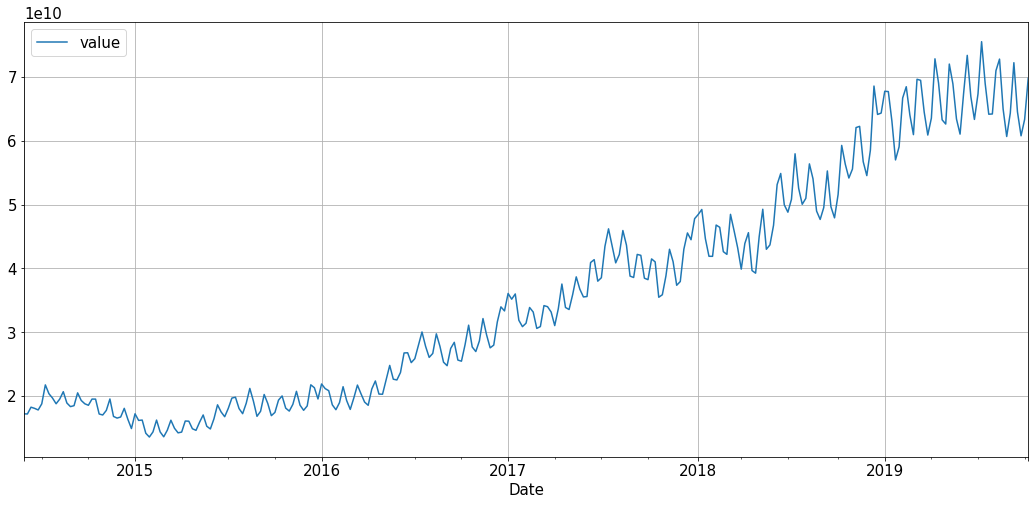

In [27]:
dataset1 = dataset.resample('W').agg('mean')

dataset1.plot(y='value')

In [28]:
dt = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dt.dropna(subset=['value'], how='all')

In [29]:
dataset1 = dataset1.interpolate()

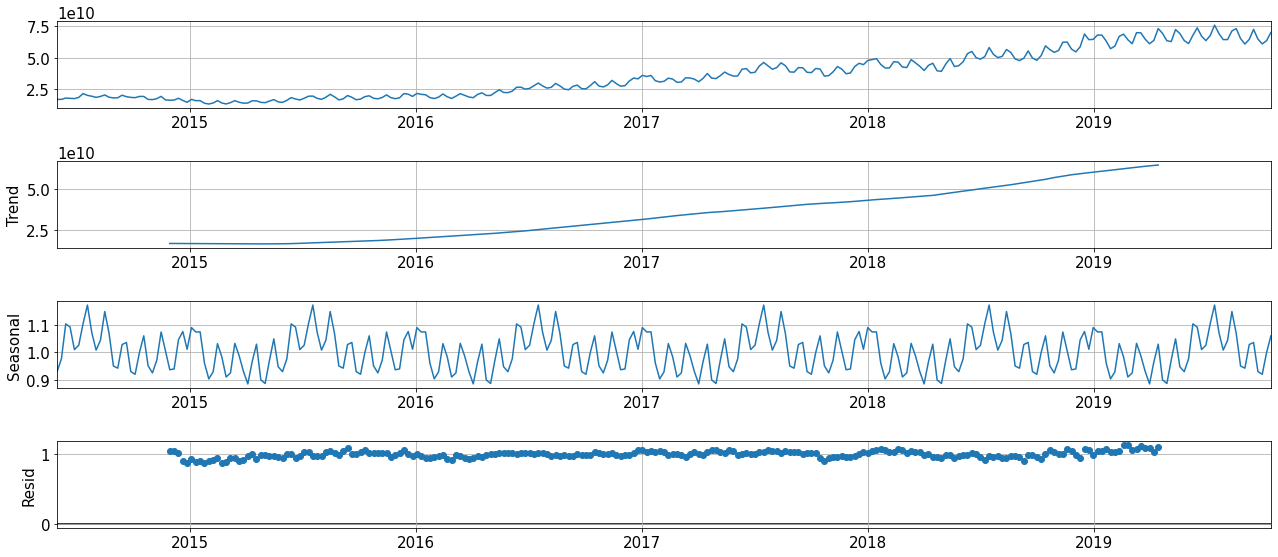

In [30]:
ts_dicomposition = seasonal_decompose(dataset1, model='multiplicate')
ts_dicomposition.plot();

Временные ряды [стационарный](https://en.wikipedia.org/wiki/Stationary_process) если они не имеют тенденции или сезонных эффектов. Наблюдения в стационарном временном ряду не зависят от времени. 

В нашем же случае можно выделить тренд и сезонность, значит ряд нестационарен

,value
count,2.810000e+02
mean,3.601341e+10
std,1.775968e+10
min,1.356953e+10
25%,1.930714e+10
50%,3.317428e+10
75%,4.882917e+10
max,7.556869e+10


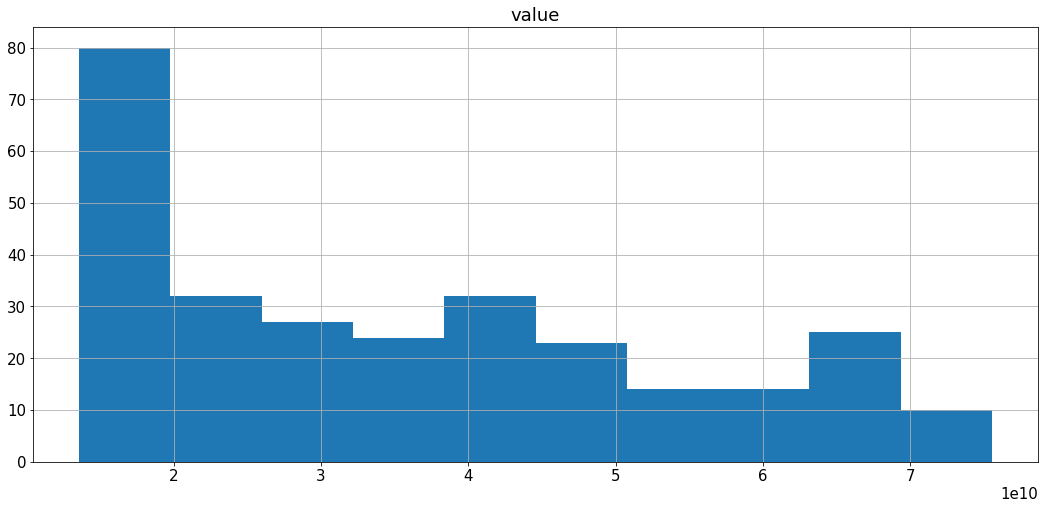

In [31]:
itog = dataset1.describe()
dataset1.hist()
itog

Можно предположить, что это логнормальное [распределение](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

Функция логарифма часто используется для моделей в экономике (например, модель спроса в ценообразование может быть описана логарифмом). Поэтому прологарифмируем наше значение, чтобы посмотреть на распределение логарифма величины.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b93c9d410>]],
      dtype=object)

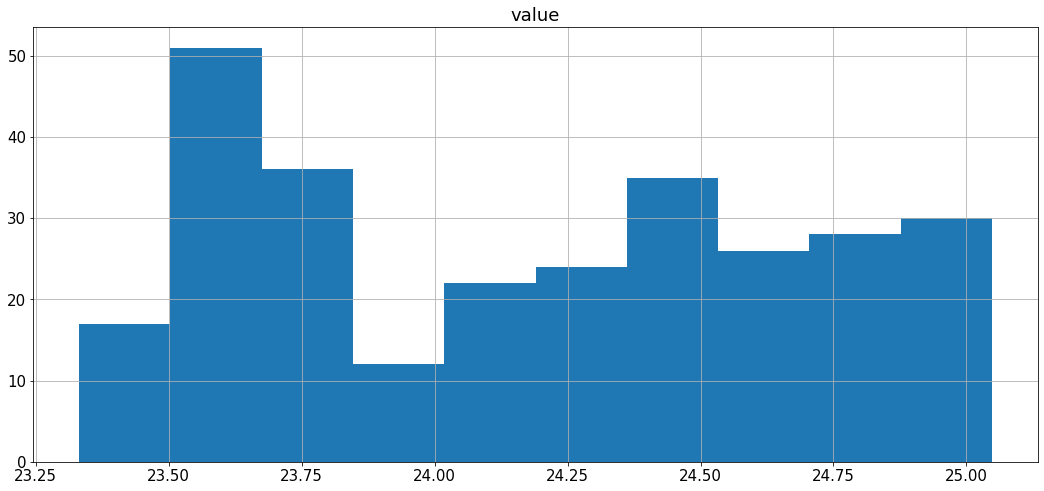

In [32]:
dataset1_log = np.log(dataset1)
dataset1_log.hist()

Прологарифмировав величину и построив гистограмму, получилось бимодальное распределение.

Заметим не однородный график. Посчитаем коэффициент вариации.

In [33]:
row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataset1)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)


          JB         
---------------------
    24.84086279256591
4.035294000646516e-06
   0.5373911747999228
   2.0169016184756328
---------------------


In [34]:
test = sm.tsa.adfuller(dataset1)

print(f'adf: {test[0]}') # может стоит использовать f-strings - форматирование строк
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд нестационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf: 1.1563885231724627
p-value:  0.9956702740792251
Critical values:  {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
есть единичные корни, ряд нестационарен


In [35]:
otgdiff = dataset1.diff(periods=1).dropna()

In [36]:
test = sm.tsa.adfuller(otgdiff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])

if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else: 
    print('единичных корней нет,ряд стационарный')
    

adf: -5.889377276673699
p-value: 2.949125111743946e-07
Critical values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
единичных корней нет,ряд стационарный


Построим график и посмотрим на тренд для графика. 

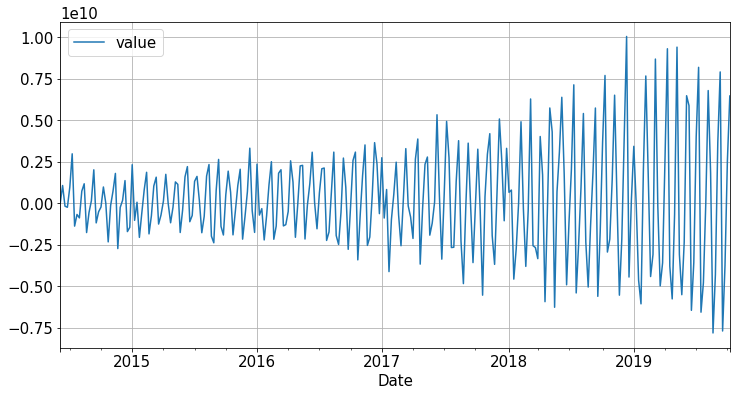

In [37]:
otgdiff.plot(figsize=(12,6))

Видим что тренда нет и таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

Проведем небольшой анализ (исходного набора) и посмотрим диаграмму рассеяния в зависимости от года, дня, месяца и дня недели.

In [38]:
dtA = dt

In [39]:
dtA.loc[:, 'date'] = dtA.index
dtA.loc[:, 'dayofweek'] = dtA['date'].dt.dayofweek
dtA.loc[:, 'quarter'] = dtA['date'].dt.quarter
dtA.loc[:, 'month'] = dtA['date'].dt.month
dtA.loc[:, 'year'] = dtA['date'].dt.year
dtA.loc[:, 'dayofyear'] = dtA['date'].dt.dayofyear
dtA.loc[:, 'dayofmonth'] = dtA['date'].dt.day
dtA.loc[:, 'weekofyear'] = dtA['date'].dt.isocalendar().week

In [40]:
dtA

,value,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2013-12-30,3457625638,2013-12-30,0,4,12,2013,364,30,1
2013-12-31,3417092149,2013-12-31,1,4,12,2013,365,31,1
2014-01-01,3417092149,2014-01-01,2,1,1,2014,1,1,1
2014-01-02,3417092149,2014-01-02,3,1,1,2014,2,2,1
2014-01-03,3417092149,2014-01-03,4,1,1,2014,3,3,1
...,...,...,...,...,...,...,...,...,...
2019-10-06,64630140507,2019-10-06,6,4,10,2019,279,6,40
2019-10-07,66115288637,2019-10-07,0,4,10,2019,280,7,41
2019-10-08,68424049766,2019-10-08,1,4,10,2019,281,8,41


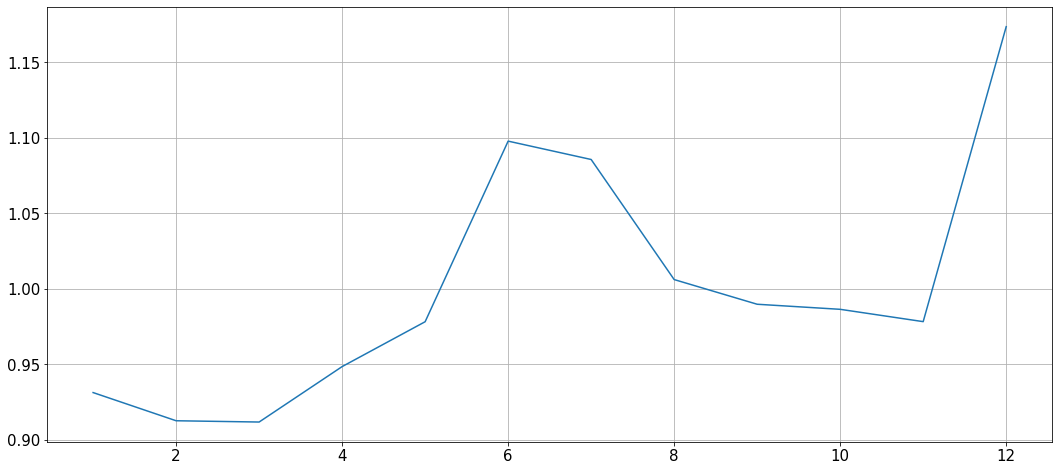

In [41]:
dtA_month = dtA.asfreq(freq='m')
ts_dicomposition = seasonal_decompose(dtA_month['value'], model='multiplicate')
plt.plot(ts_dicomposition.seasonal[1:13].index.month, ts_dicomposition.seasonal[1:13].values)

In [42]:
fig = px.scatter(dtA, x='dayofmonth',y='value')
fig.update_layout(title="Values by years")
fig.show()

<a id="section_ch_0"></a>

In [43]:
dtA_by_month = dtA.groupby('month')['value'].median().reset_index()

fig = px.line(dtA_by_month, x='month', y='value')
fig.update_layout(title="Median values by month")
fig.show()

In [44]:
dtA_by_dayofmonth = dtA.groupby('dayofmonth')['value'].median().reset_index()

fig = px.line(dtA_by_dayofmonth, x='dayofmonth', y='value')
fig.update_layout(title="Median values by month")
fig.show()

In [45]:

dtA_by_dayofmonth = dtA.groupby('dayofweek')['value'].median().reset_index()

fig = px.line(dtA_by_dayofmonth, x='dayofweek', y='value')
fig.update_layout(title="Median values by month")
fig.show()

Выводы из проведенного анализа визуализации:

 * значения увеличиваются в 2019 году
 * значения увеличиваются к середине года и падают к концу
 * С 10-го по 15-е число заметно увеличение баланса счета.
 * максимальные значения по выходным и средам.

<a id="section_3"></a>

# Минимум в месяц(baseline) - линейная регрессия


предскажем минимальное значение объема,при подготовке обучающих данных при группировке по месяцу возьмем минимальные значения.

$$ mint \in time(value0..valuet) $$ 











In [ ]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dataset.dropna(subset=['value'], how='all')

In [ ]:
df_min = dataset1.groupby(pd.Grouper(axis=0, freq='m')).min()

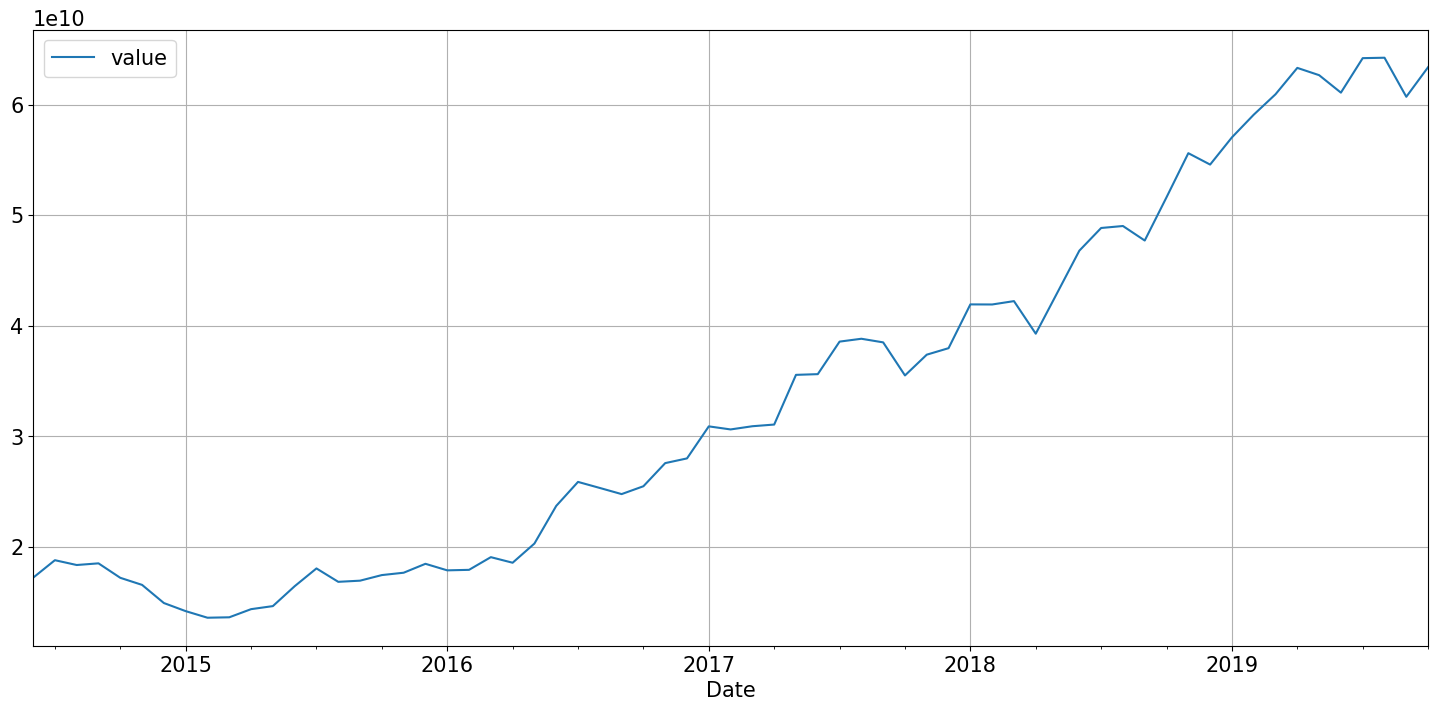

In [ ]:
df_min.plot(y='value');

Train dates : 2014-06-30 00:00:00 --- 2019-04-30 00:00:00  (n=59)
Test dates  : 2019-05-31 00:00:00 --- 2019-10-31 00:00:00  (n=6)


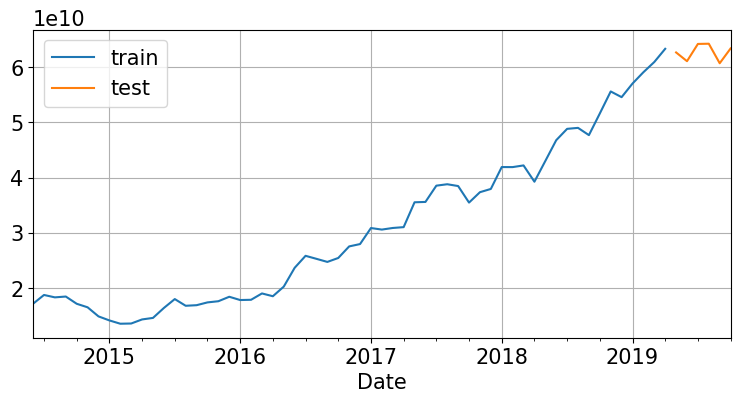

In [ ]:
steps = 6
data_train = df_min[:-steps]
data_test  = df_min[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_min = df.copy(deep=True)
    df_min['date'] = df_min.index
    df_min['dayofweek'] = df_min['date'].dt.dayofweek
    df_min['quarter'] = df_min['date'].dt.quarter
    df_min['month'] = df_min['date'].dt.month
    df_min['year'] = df_min['date'].dt.year
    df_min['dayofyear'] = df_min['date'].dt.dayofyear
    df_min['dayofmonth'] = df_min['date'].dt.day
    df_min['weekofyear'] = df_min['date'].dt.isocalendar().week
    
    X = df_min[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_min[label]
        return X, y
    return X


X_test, y_test = create_features(data_test, label='value')
X_train, y_train = create_features(data_train, label='value')

Попробуем лин регрессию

In [ ]:
feature_name = X_train.columns

scalerX = StandardScaler()
scalerX.fit(X_train) 
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

scalerY = StandardScaler()
scalerY.fit(y_train.values.reshape(-1, 1)) 
y_train = scalerY.transform(y_train.values.reshape(-1, 1))
y_test = scalerY.transform(y_test.values.reshape(-1, 1))

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_

sorted(list(zip(feature_name, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek',
  array([  0.01888384,   0.15729202,  15.74371535,   0.98206519,
         -15.63205951,   0.04413496,  -0.08453572]))]

In [ ]:
pd.DataFrame({
    'variable': feature_name,
    'coef': model.coef_[0] 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,15.740000
3,year,0.980000
1,quarter,0.160000
5,dayofmonth,0.040000
0,dayofweek,0.020000
6,weekofyear,-0.080000
4,dayofyear,-15.630000


In [ ]:
y_predict = model.predict(X_test)
y_predict

array([[1.75447855],
       [1.80280507],
       [1.88785349],
       [1.85145868],
       [1.82815119],
       [1.98483362]])

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test, y_predict))

Mean Squared Error: 0.15716387334809206
Root Mean Squared Error: 0.39643899070108135
Mean Absolute Error: 0.38575303824735724
R2 -15.500549972747855


In [ ]:
y_predict = scalerY.inverse_transform(y_predict)

In [ ]:
for_sub = pd.DataFrame(y_predict, index=data_test.index)
for_sub = for_sub.rename({0:'min_value_pred'}, axis=1)

for_sub.min_value_pred = for_sub.min_value_pred.round().astype('int')

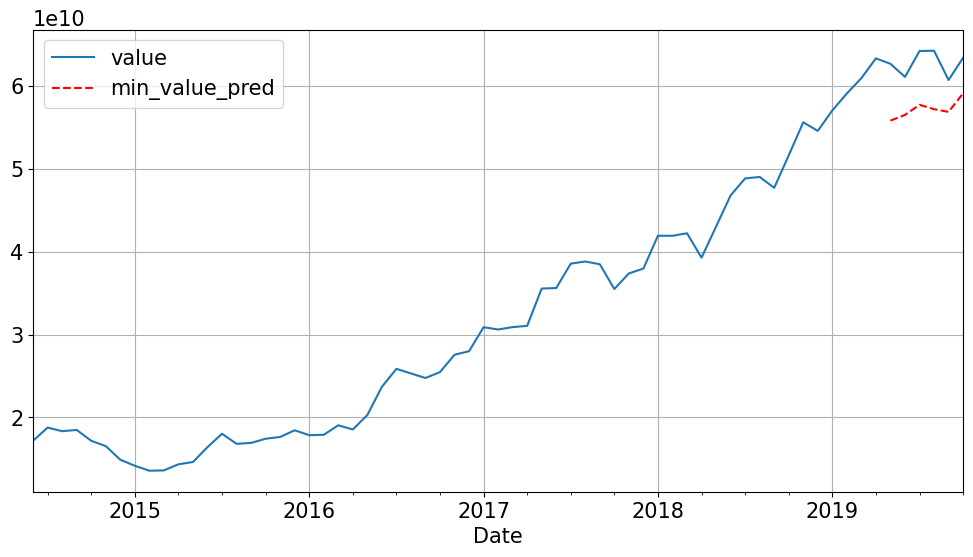

In [ ]:
ax = df_min.plot(figsize=(12,6))
for_sub.plot(style='r--', ax=ax);

<a id="section_ch_1"></a>
# Попробуем xgboost

Все модели должны тестироваться на этом промежутке
Train dates : 2014-06-30 00:00:00 --- 2019-05-31 00:00:00  (n=60)
Test dates  : 2019-06-30 00:00:00 --- 2019-10-31 00:00:00  (n=5)

In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)

In [ ]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('R2', r2_score(y_test, y_pred))

Mean Squared Error: 0.029734280559637376
Root Mean Squared Error: 0.17243630870451088
Mean Absolute Error: 0.15551968701172866
R2 -2.121786017524095


In [ ]:
y_predict = scalerY.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
for_sub_xgboost = pd.DataFrame(y_predict, index=data_test.index)
for_sub_xgboost = for_sub_xgboost.rename({0:'min_value_pred'}, axis=1)

for_sub_xgboost.min_value_pred = for_sub_xgboost.min_value_pred.round().astype('int')

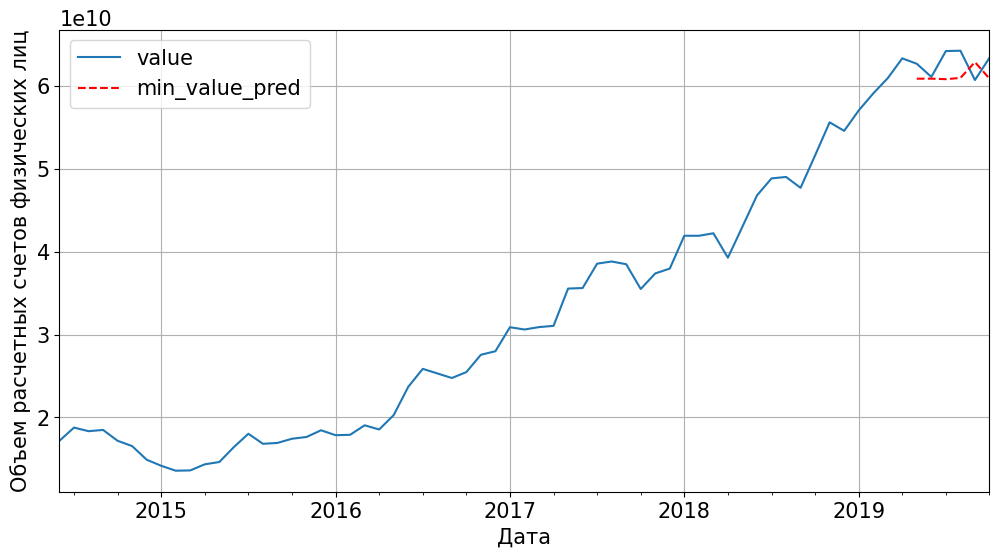

In [ ]:
ax = df_min.plot(figsize=(12,6))
for_sub_xgboost.plot(style='r--', ax=ax);
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

<a id="section_ch_2"></a>
# SARIMAX Попробуем рассмотреть сезонность и тренд 

как в примере https://datastud.dev/posts/python-arima-how-to

In [ ]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

In [ ]:
def create_features(df_min, label=None):
    """
    Creates time series features from datetime index
    """
    df_min.loc[:, 'date'] = df_min.index
    df_min.loc[:,'dayofweek'] = df_min['date'].dt.dayofweek
    df_min.loc[:, 'quarter'] = df_min['date'].dt.quarter
    df_min.loc[:, 'month'] = df_min['date'].dt.month
    df_min.loc[:, 'year'] = df_min['date'].dt.year
    df_min.loc[:, 'dayofyear'] = df_min['date'].dt.dayofyear
    df_min.loc[:, 'dayofmonth'] = df_min['date'].dt.day
    df_min.loc[:, 'weekofyear'] = df_min['date'].dt.weekofyear
    
    x = df_min.drop('date', axis=1)
    if label:
        y = df_min[label]
        return x, y
    return x


df_min = create_features(df_min)

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/3625758581.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [ ]:
# Re-Run Seasonal Decompose (train data only) 
sd = seasonal_decompose(df_min['value'], model='multiplicate')
combine_seasonal_cols(df_min, sd)


In [ ]:
df_min['residual'] = df_min['residual'].fillna(df_min['residual'].mean())
df_min['trend'] = df_min['trend'].interpolate()

In [ ]:
df_min['trend'].info()
df_min['trend'] = df_min['trend'].bfill()

<class 'pandas.core.series.Series'>
DatetimeIndex: 65 entries, 2014-06-30 to 2019-10-31
Freq: M
Series name: trend
Non-Null Count  Dtype  
--------------  -----  
59 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


In [ ]:
df_min['trend_plus_resid'] = df_min['trend'] * df_min['residual']
df_min = df_min[df_min.trend_plus_resid.notnull()]

In [ ]:
df_train = df_min[:'2019-04-30']
df_test = df_min['2019-05-31':]

In [ ]:
# Sarimax
sarimax = sm.tsa.statespace.SARIMAX(
    df_train.trend_plus_resid, 
    order=(1, 0, 0) # to be tuned/optimized in a future article
) 
res = sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74443D+02    |proj g|=  6.80017D+02

At iterate    5    f=  2.82666D+01    |proj g|=  7.22009D+00

At iterate   10    f=  2.34069D+01    |proj g|=  3.36809D-01

At iterate   15    f=  2.28486D+01    |proj g|=  1.65598D-02

At iterate   20    f=  2.27829D+01    |proj g|=  6.63226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     25      1     0     0   9.947D-06   2.278D+01
  F =   22.780182269748003     

CONVERG

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


In [ ]:
# Make trend forecast
df_test['trend_prediction'] = res.predict(
    start=np.min(df_test.index), 
    end=np.max(df_test.index)
)

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/105690003.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test

,value,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,observed,residual,seasonal,trend,trend_plus_resid,trend_prediction
Date,,,,,,,,,,,,,,
2019-05-31,6.265431e+10,4,2,5,2019,151,31,22,6.265431e+10,0.990672,0.979640,6.007071e+10,5.951039e+10,6.659560e+10
2019-06-30,6.107306e+10,6,2,6,2019,181,30,26,6.107306e+10,0.990672,1.042232,6.007071e+10,5.951039e+10,6.657127e+10
2019-07-31,6.419393e+10,2,3,7,2019,212,31,31,6.419393e+10,0.990672,1.093525,6.007071e+10,5.951039e+10,6.654694e+10
2019-08-31,6.423243e+10,5,3,8,2019,243,31,35,6.423243e+10,0.990672,1.039983,6.007071e+10,5.951039e+10,6.652262e+10
2019-09-30,6.069904e+10,0,3,9,2019,273,30,40,6.069904e+10,0.990672,0.996305,6.007071e+10,5.951039e+10,6.649832e+10
2019-10-31,6.337633e+10,3,4,10,2019,304,31,44,6.337633e+10,0.990672,0.980719,6.007071e+10,5.951039e+10,6.647402e+10


In [ ]:
# Add Seasonal component
seasonal_prediction = df_train[-12:].reset_index()[['month', 'seasonal']]

df_test = df_test.reset_index().merge(
    seasonal_prediction, 
    how='left', 
    left_on='month', 
    right_on='month'
).set_index('Date')

df_test['combined_prediction'] =  df_test['trend_prediction'] * df_test['seasonal_x']

# Add to orignal df for visualization
df_min['prediction'] = df_test['combined_prediction']

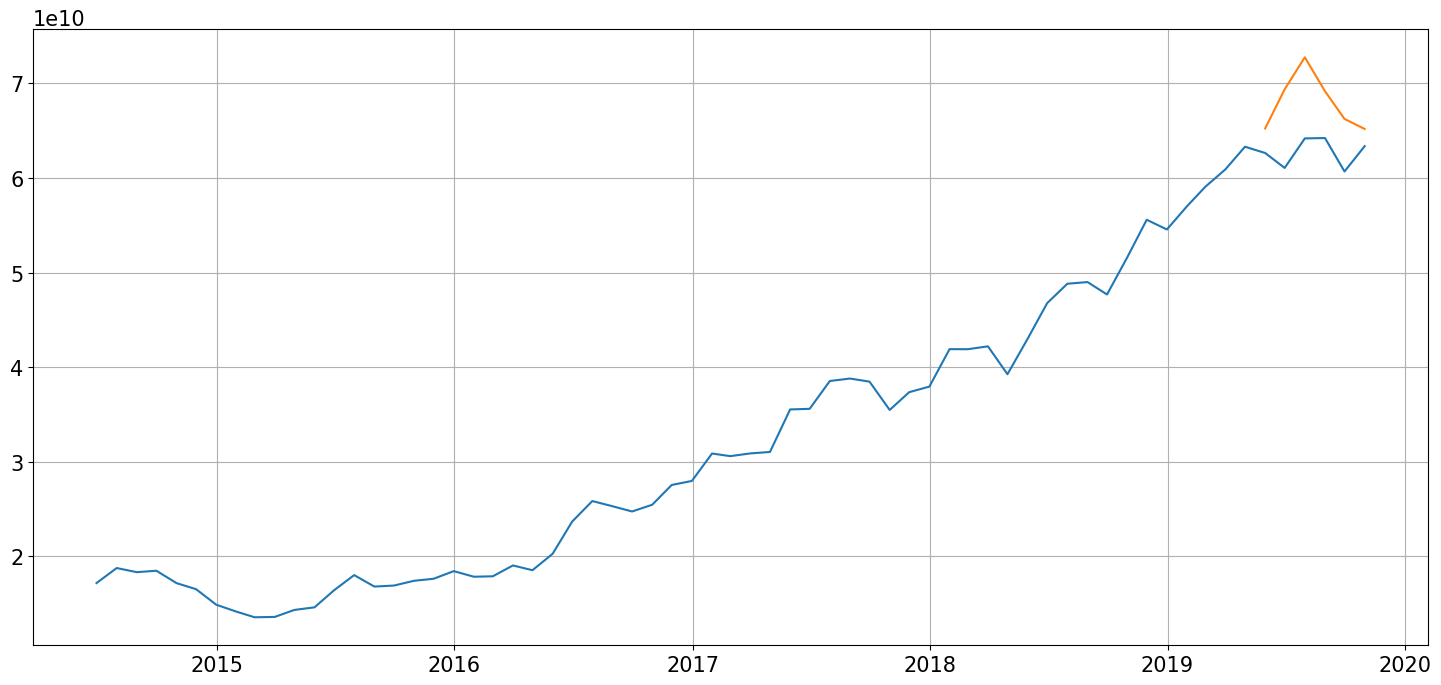

In [ ]:
plt.plot(df_min['value'])
plt.plot(df_min['prediction'])

In [ ]:
y_predict = df_test['combined_prediction']
y_test = df_test['value']

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))


Mean Squared Error: 3.4656461553032266e+19
Root Mean Squared Error: 5886973887.578597
Mean Absolute Error: 5298575778.082519
R2 -16.787245640430097


<a id='Arima '></a>

# Arima 

**Построение модели** 


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

/usr/local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



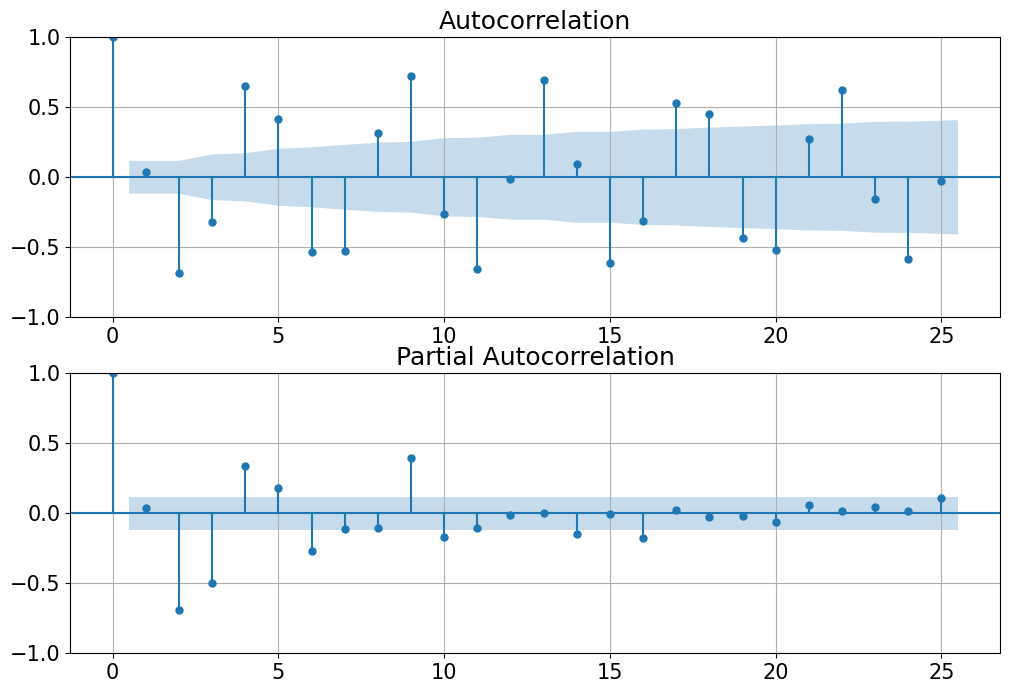

In [ ]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otgdiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otgdiff, lags=25, ax=ax2)

In [ ]:
src_data_model = dataset1[:'2019-06-10']
model = sm.tsa.ARIMA(src_data_model, order=(3, 2, 2), freq='W').fit()

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  263
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -5976.483
Date:                Wed, 19 Oct 2022   AIC                          11964.965
Time:                        19:37:26   BIC                          11986.353
Sample:                    06-01-2014   HQIC                         11973.562
                         - 06-09-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3807      0.056     -6.807      0.000      -0.490      -0.271
ar.L2         -0.8108      0.017    -46.986      0.000      -0.845      -0.777
ar.L3         -0.6143      0.050    -12.195      0.0

In [ ]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

In [ ]:
pred = model.predict('2019-05-26','2020-01-31', typ='levels')
trn = dataset1['2019-05-26':]
r2 = r2_score(trn, pred[0:len(trn)])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(trn, pred[0:len(trn)]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trn, pred[0:len(trn)])))
print('Mean Absolute Error:', metrics.mean_absolute_error(trn, pred[0:len(trn)])) 

R^2: 0.68
Mean Squared Error: 5.896662371758127e+18
Root Mean Squared Error: 2428304423.205239
Mean Absolute Error: 1976489972.076952


Попробуем предсказать...

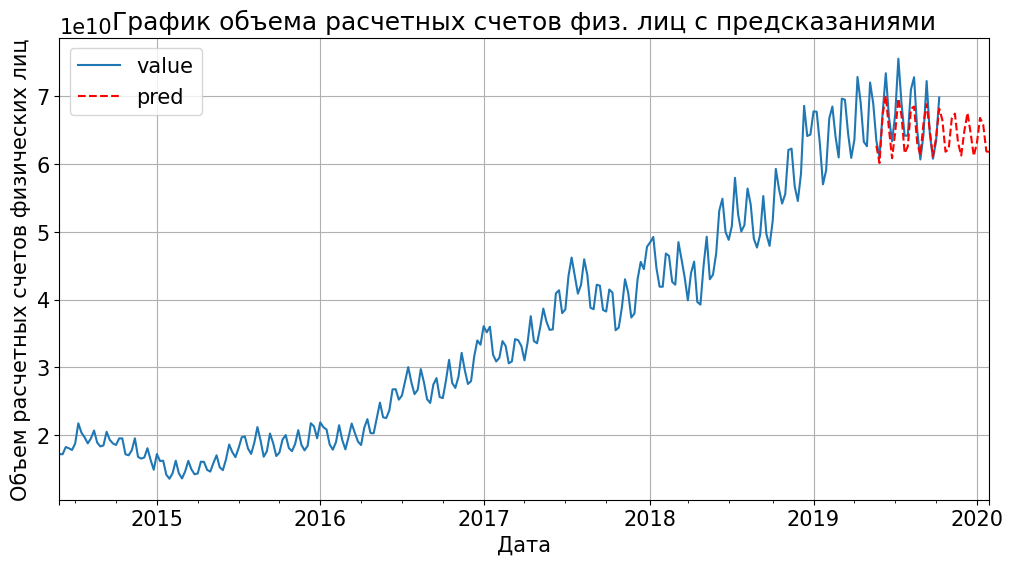

In [ ]:
dataset1.plot(figsize=(12,6), title='График объема расчетных счетов физ. лиц c предсказаниями')
ax=pred.plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

In [ ]:
dt_pred=dataset1['2019-05-15':]


dt_pred['pred']=pred
dt_pred.head(15)

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/3566861458.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,pred
Date,,
2019-05-19,6.896488e+10,NaN
2019-05-26,6.344489e+10,6.272516e+10
2019-06-02,6.107306e+10,6.017969e+10
2019-06-09,6.754772e+10,6.733953e+10
2019-06-16,7.342399e+10,7.012084e+10
2019-06-23,6.696145e+10,6.521118e+10
2019-06-30,6.337888e+10,6.087851e+10
2019-07-07,6.738229e+10,6.478990e+10
2019-07-14,7.556869e+10,6.969220e+10


# SARIMA

Попробуем  предсказать ряд с помощью SARIMA

In [47]:
df=dataset1

In [49]:
def combine_seasonal_cols(input_df, seasonal_model_results):
   
    
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

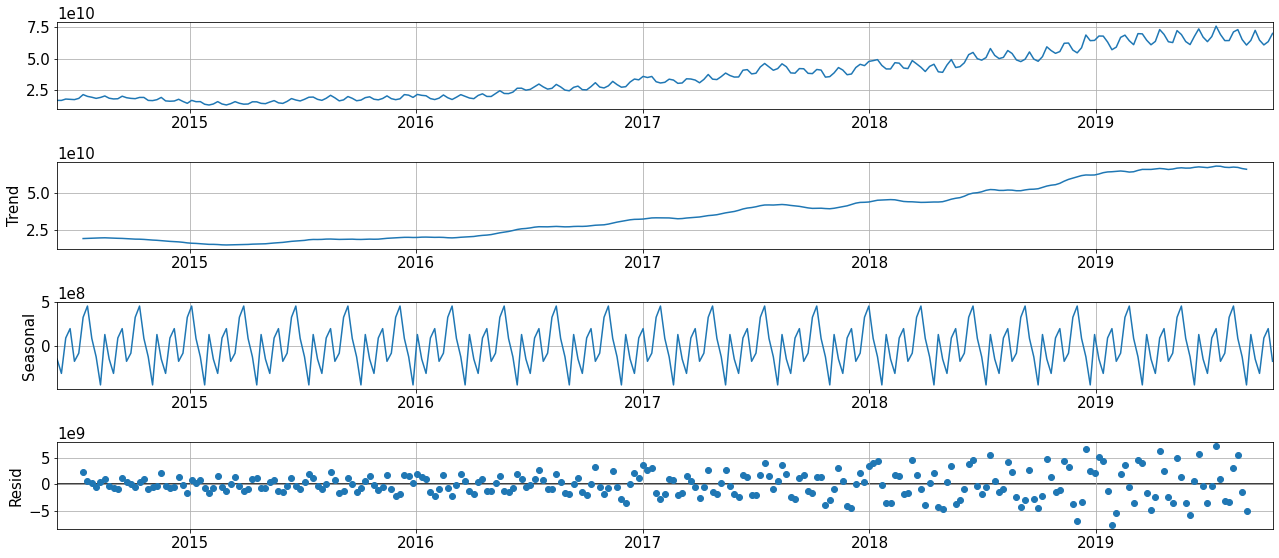

In [50]:
sd = seasonal_decompose(df, period=12)

sd.plot();


In [51]:
combine_seasonal_cols(df, sd) 

In [ ]:
df_train_S = df[:'2019-01-05']
df_test_S = df['2019-01-05':]

In [ ]:
df_train_S['trend_plus_resid'] = df_train_S['trend'] + df_train_S['residual']
df_train_S = df_train_S[df_train_S.trend_plus_resid.notnull()]

df_test_S['trend_plus_resid'] = df_test_S['trend'] +df_test_S['residual']
df_test_S = df_test_S[df_test_S.trend_plus_resid.notnull()]

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/3998904108.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/3998904108.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model=sm.tsa.statespace.SARIMAX(df_train_S['value'],
                                order=(3, 1, 2),
                                seasonal_order=(3,2,1, 12))
results=model.fit()

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13738D+01    |proj g|=  7.50965D-01

At iterate    5    f=  2.07297D+01    |proj g|=  4.57441D-02

At iterate   10    f=  2.07026D+01    |proj g|=  3.45034D-02

At iterate   15    f=  2.06978D+01    |proj g|=  1.29323D-02

At iterate   20    f=  2.06885D+01    |proj g|=  7.11074D-02

At iterate   25    f=  2.06839D+01    |proj g|=  1.15263D-01

At iterate   30    f=  2.06784D+01    |proj g|=  1.06901D-01

At iterate   35    f=  2.06764D+01    |proj g|=  4.97889D-02

At iterate   40    f=  2.06742D+01    |proj g|=  8.17118D-02

At iterate   45    f=  2.06719D+01    |proj g|=  1.29799D-01


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.06691D+01    |proj g|=  6.30577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   6.306D-02   2.067D+01
  F =   20.669070490615436     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.



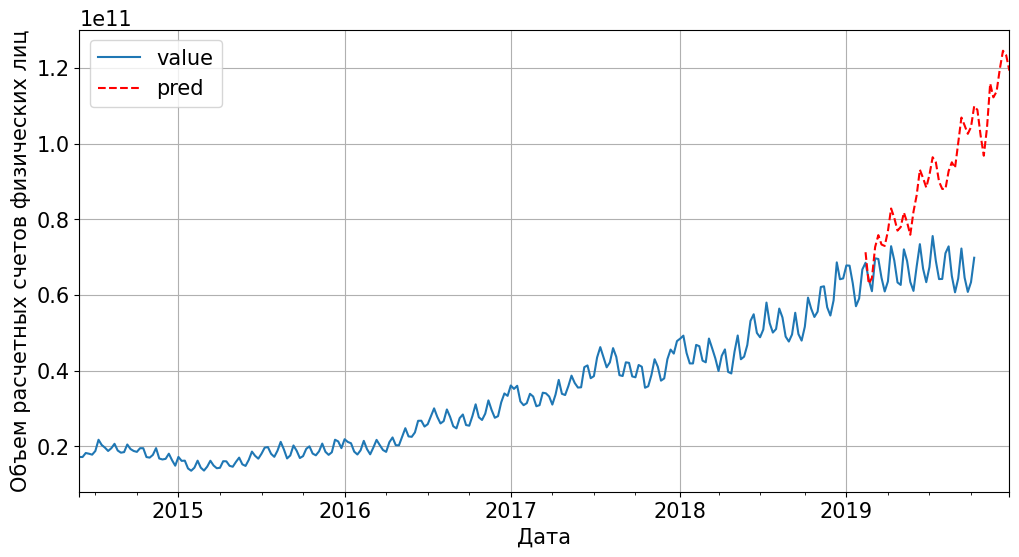

In [ ]:
df['value'].plot(figsize=(12,6))
ax=results.predict(start=240,end=285,dynamic=True).plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

In [ ]:
df_test_S['pred']=pred

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/1694593786.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test_S=df_test_S['2019-05-26':]

In [ ]:
r2 = r2_score(df_test_S['value'], df_test_S['pred'])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(df_test_S['value'], df_test_S['pred']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_test_S['value'], df_test_S['pred'])))
print('Mean Absolute Error:', metrics.mean_absolute_error(df_test_S['value'], df_test_S['pred'])) 

R^2: 0.63
Mean Squared Error: 7.080269162285405e+18
Root Mean Squared Error: 2660877517.3399854
Mean Absolute Error: 2237594665.1363573


# LSTM

Попробуем предсказать с помощью LSTM

In [181]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [182]:
dataset = dataset1.value.values
dataset = dataset.astype('float32')

In [183]:
dataset = dataset.reshape(-1,1)

Правильнее нормализовать данные после раздение на тестовую и обучающую выборки. В случае, если нормализацию производить до разделения, то информация из тестовой выборки "попадает" в обучающую. Потому что мы вычисляем максимум и минимум по выборке из теста и из трейна.

MinMaxScaler очень чувствителен к выбросам, можно посмотреть другие функции для нормализации данных.

In [184]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [185]:
len(dataset)


281

In [210]:
# split into train and test sets
train_size = int(len(dataset) * 0.86)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

241 40


In [209]:
def create_dataset(dataset, look_back=1):
    """
    Эта функция "вытягивает" датасет. 
    
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [207]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [208]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [190]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=250, batch_size=5, verbose=2)

Epoch 1/250
48/48 - 2s - loss: 0.1016 - 2s/epoch - 40ms/step
Epoch 2/250
48/48 - 0s - loss: 0.0708 - 82ms/epoch - 2ms/step
Epoch 3/250
48/48 - 0s - loss: 0.0512 - 87ms/epoch - 2ms/step
Epoch 4/250
48/48 - 0s - loss: 0.0395 - 84ms/epoch - 2ms/step
Epoch 5/250
48/48 - 0s - loss: 0.0334 - 86ms/epoch - 2ms/step
Epoch 6/250
48/48 - 0s - loss: 0.0302 - 87ms/epoch - 2ms/step
Epoch 7/250
48/48 - 0s - loss: 0.0279 - 87ms/epoch - 2ms/step
Epoch 8/250
48/48 - 0s - loss: 0.0258 - 87ms/epoch - 2ms/step
Epoch 9/250
48/48 - 0s - loss: 0.0238 - 84ms/epoch - 2ms/step
Epoch 10/250
48/48 - 0s - loss: 0.0217 - 84ms/epoch - 2ms/step
Epoch 11/250
48/48 - 0s - loss: 0.0196 - 104ms/epoch - 2ms/step
Epoch 12/250
48/48 - 0s - loss: 0.0176 - 88ms/epoch - 2ms/step
Epoch 13/250
48/48 - 0s - loss: 0.0156 - 84ms/epoch - 2ms/step
Epoch 14/250
48/48 - 0s - loss: 0.0136 - 92ms/epoch - 2ms/step
Epoch 15/250
48/48 - 0s - loss: 0.0118 - 89ms/epoch - 2ms/step
Epoch 16/250
48/48 - 0s - loss: 0.0100 - 89ms/epoch - 2ms/step
E

In [191]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 6ms/step


Далее необходимо примень обратное преобразование по MinMaxScaler, чтобы вернуться к исходным величинам

In [192]:
pred = scaler.inverse_transform(testPredict)[:, 0]

Но для оценки предсказания, главное посчитать метрики (для этого не обязательно переходить к исходных величинам)

In [193]:
testPredict = testPredict.reshape(1, -1)[0]

In [194]:
r2 = r2_score(testY, testPredict)

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(testY, testPredict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, testPredict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, testPredict)) 

R^2: -0.40
Mean Squared Error: 0.0070516183
Root Mean Squared Error: 0.083973914
Mean Absolute Error: 0.06696642


In [213]:
df_trainY = pd.DataFrame(trainY, index=dataset1.index[0:len(train)-2])
df_testY = pd.DataFrame(testY, index=dataset1.index[len(train):len(dataset)-2])

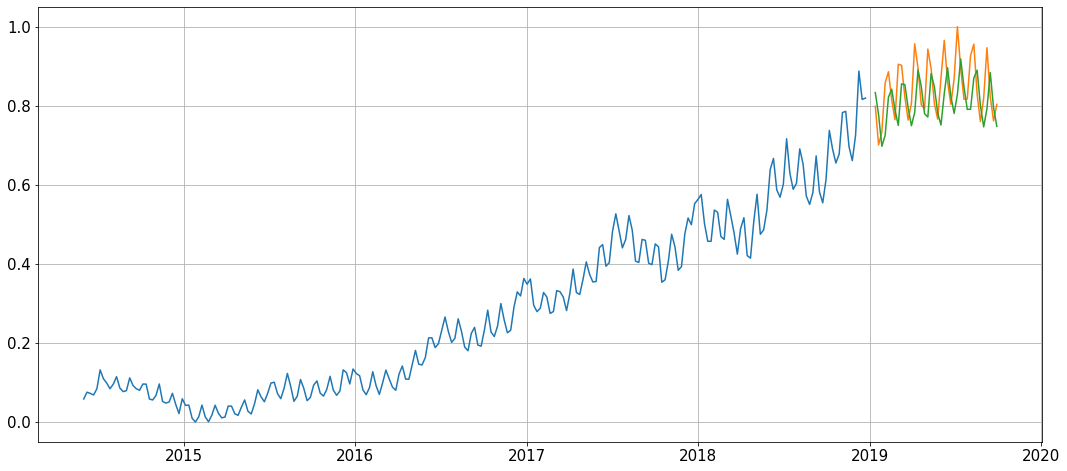

In [214]:
plt.plot(df_trainY.index, df_trainY.values)
plt.plot(df_testY.index, df_testY.values)
plt.plot(df_testY.index, testPredict,label='pred' )
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

# Skforecast

Попрробуем еще так(тоже как то неочень )

In [ ]:
# !pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 305.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 334.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 155.4 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 93.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 98.0 kB/s eta 0:00:0000:01m0:03m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 213.0 kB/s eta 0:00:0000:0100:03
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 48.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 217.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 259.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.

In [ ]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

Попробуем библиотеку Skforecast (спойлер предсказания тоже такие себе) 

Train dates : 2014-06-01 00:00:00 --- 2019-02-03 00:00:00  (n=245)
Test dates  : 2019-02-10 00:00:00 --- 2019-10-13 00:00:00  (n=36)


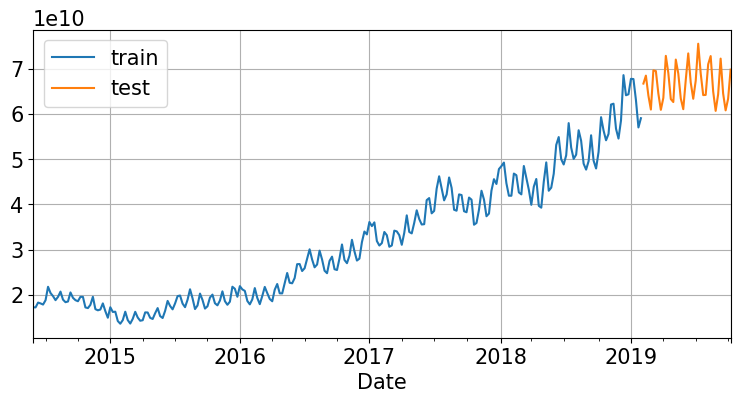

In [ ]:
steps = 36
data_train = dataset1[:-steps]
data_test  = dataset1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['value'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2019-02-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-19 19:55:53 
Last fit date: 2022-10-19 19:55:53 
Skforecast version: 0.5.1 
Python version: 3.10.7 

In [ ]:
# Predictions
# ==============================================================================
steps = 36

predictions = forecaster.predict(steps=steps)

data_test.loc[:, 'pred'] = predictions
data_test.head(15)

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/3711350496.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,observed,residual,seasonal,trend,pred
Date,,,,,,
2019-02-10,6.674185e+10,6.674185e+10,1.932487e+09,-8.249434e+07,6.489186e+10,6.140721e+10
2019-02-17,6.850709e+10,6.850709e+10,3.566142e+09,3.291297e+08,6.461182e+10,6.230516e+10
2019-02-24,6.408280e+10,6.408280e+10,-5.270496e+08,4.580809e+08,6.415177e+10,6.099774e+10
2019-03-03,6.099172e+10,6.099172e+10,-3.480102e+09,8.611252e+07,6.438571e+10,6.280820e+10
2019-03-10,6.967669e+10,6.967669e+10,4.505701e+09,-1.248602e+08,6.529585e+10,6.396835e+10
2019-03-17,6.951006e+10,6.951006e+10,3.982056e+09,-4.467900e+08,6.597480e+10,6.536895e+10
2019-03-24,6.452308e+10,6.452308e+10,-1.589103e+09,1.312153e+08,6.598097e+10,6.549136e+10
2019-03-31,6.092624e+10,6.092624e+10,-4.881802e+09,-1.505831e+08,6.595863e+10,6.572042e+10
2019-04-07,6.357528e+10,6.357528e+10,-2.420000e+09,-3.147291e+08,6.631001e+10,6.544398e+10


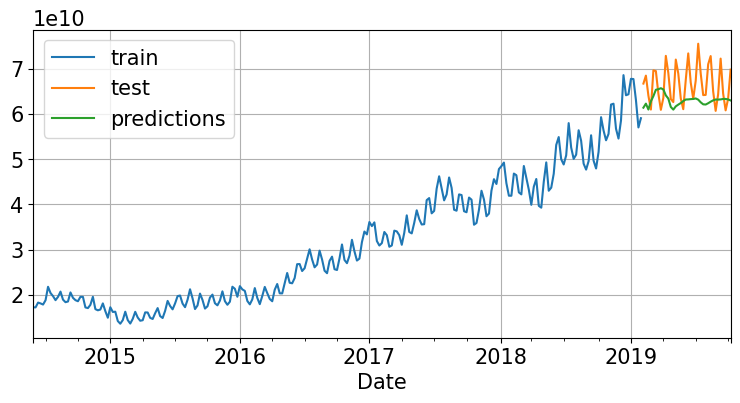

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 3.0806186296482873e+19
Root Mean Squared Error: 5550332088.846835
Mean Absolute Error: 4474661438.167772
R2 -0.8465612232783197


In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 40
             )

forecaster.fit(y=data_train['value'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

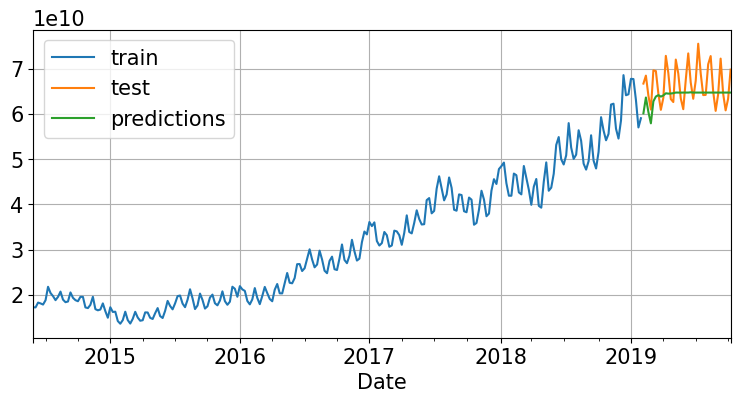

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 2.2553151600134337e+19
Root Mean Squared Error: 4749015855.957352
Mean Absolute Error: 3830738671.193331
R2 -0.3518640316824977


<a id="section_ch_last"></a>
# Обогатим данные

Попробуем обогатить данные и добавить курс $ и € 

Нет смысла добавлять и доллар и евро - так как они коррелируют (см. графики ниже) \
Так же здесь шаг предсказания - день, тогда как выше - месяц, не верно будет сравнивать эти модели

df_with_currency = df_with_currency.asfreq('M')

In [ ]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dataset.dropna(subset=['value'], how='all')

In [ ]:
dt_usd = pd.read_csv('usd.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'],    
                   infer_datetime_format="%d/%m/%y")

In [ ]:
dt_eur = pd.read_csv('eur.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   infer_datetime_format="%d/%m/%y")

In [ ]:
usd_eur = pd.concat([dt_eur, dt_usd['usd']], axis=1)


Text(0.5, 0, 'Дата')

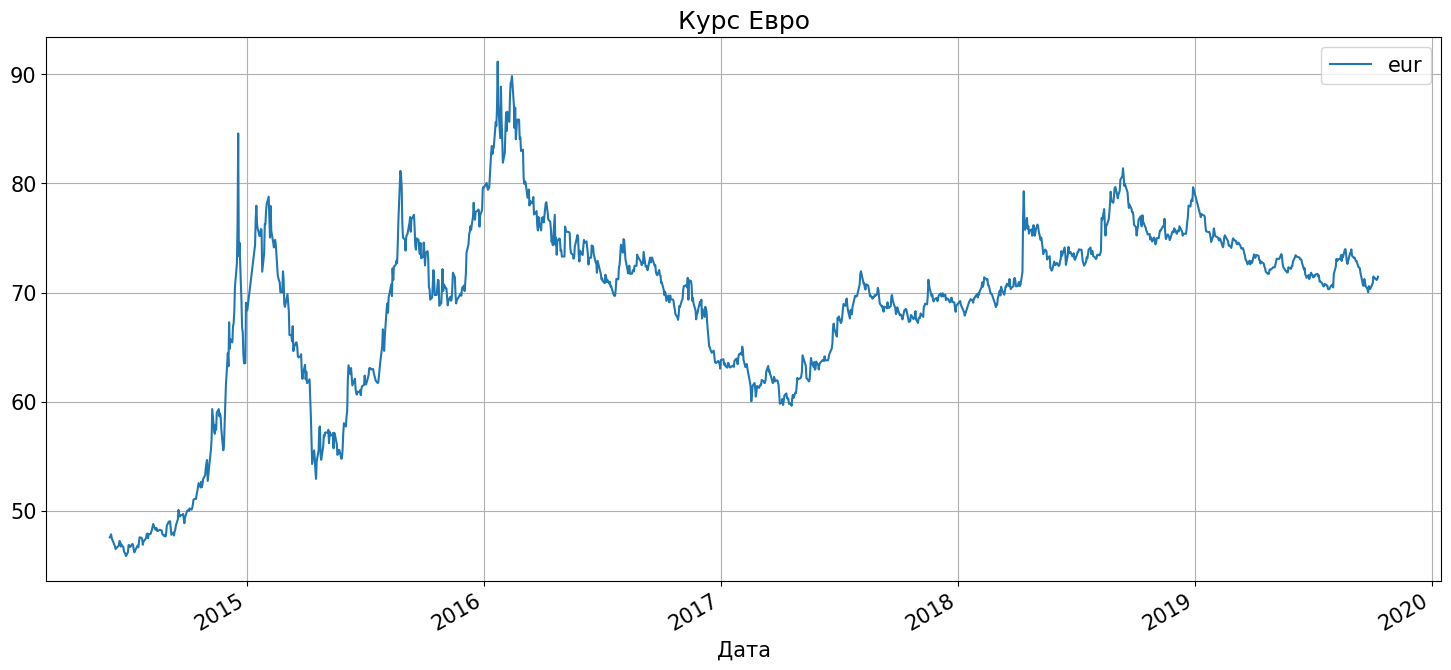

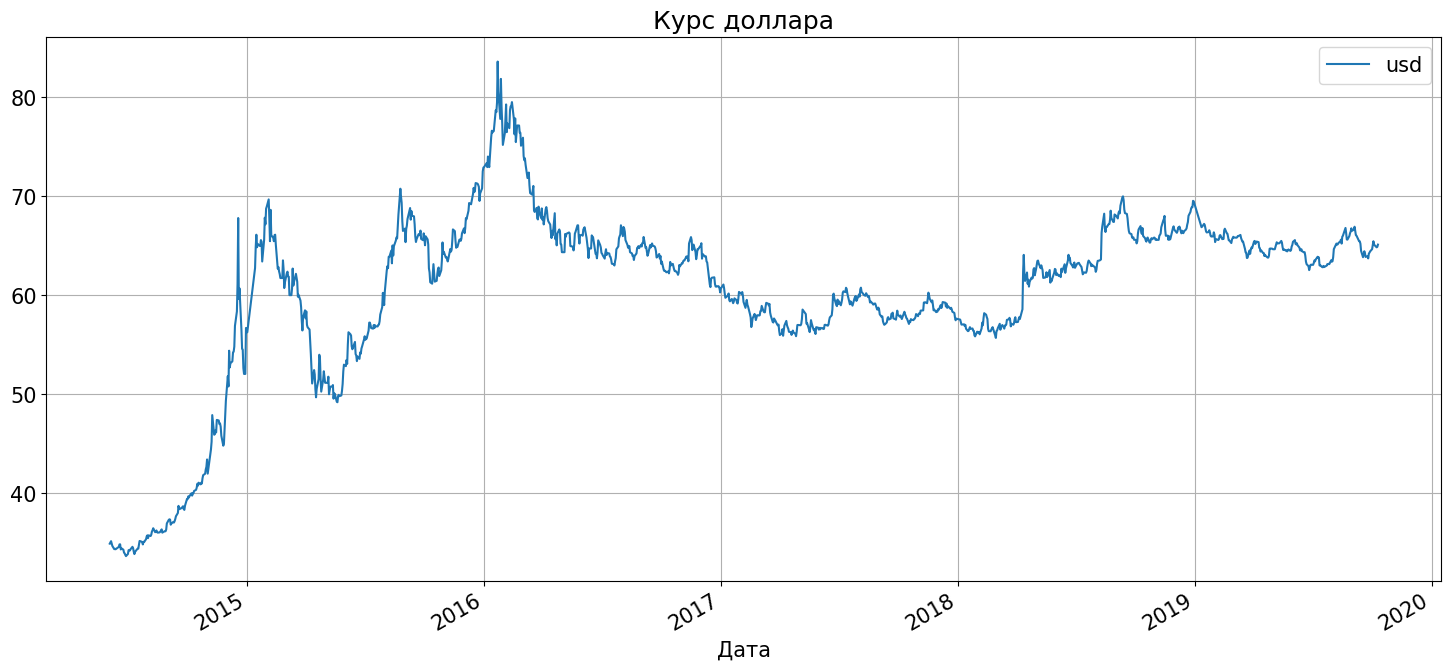

In [ ]:
ax = usd_eur.plot(y='eur', title='Курс Евро')
ax.set_xlabel("Дата")
ex = usd_eur.plot(y='usd', title='Курс доллара')
ex.set_xlabel("Дата")


Можем предположить, что объем счетов физ. лиц зависит от курса $ и €

In [ ]:
df_with_currency = pd.concat([dataset, usd_eur], axis=1)


In [ ]:
df_with_currency = df_with_currency[~df_with_currency.value.isna()]

In [ ]:
df_with_currency = df_with_currency[df_with_currency.index > '2014-06-02']

Заполняем пропуски предыдущими значениями - так как пропущенные значения по валюте - это выходные дни, получается, что в выходные дни у нас стоимость доллара сохраняется с пятницы.

In [ ]:
df_with_currency.loc[:, 'usd'] = df_with_currency['usd'].ffill()
df_with_currency.loc[:, 'eur'] = df_with_currency['eur'].ffill()

In [ ]:

df_with_currency.loc[:, 'date'] = df_with_currency.index 
df_with_currency.loc[:, 'dayofweek'] = df_with_currency['date'].dt.dayofweek
df_with_currency.loc[:, 'quarter'] = df_with_currency['date'].dt.quarter
df_with_currency.loc[:, 'month'] = df_with_currency['date'].dt.month
df_with_currency.loc[:, 'year'] = df_with_currency['date'].dt.year
df_with_currency.loc[:, 'dayofyear'] = df_with_currency['date'].dt.dayofyear
df_with_currency.loc[:, 'dayofmonth'] = df_with_currency['date'].dt.day
df_with_currency.loc[:, 'weekofyear'] = df_with_currency['date'].dt.isocalendar().week 

df_with_currency = df_with_currency.drop('date', axis=1)

X = df_with_currency[['eur',	'usd','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]



In [ ]:
df_with_currency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1956 entries, 2014-06-03 to 2019-10-10
Freq: D
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       1956 non-null   int64  
 1   eur         1956 non-null   float64
 2   usd         1956 non-null   float64
 3   dayofweek   1956 non-null   int64  
 4   quarter     1956 non-null   int64  
 5   month       1956 non-null   int64  
 6   year        1956 non-null   int64  
 7   dayofyear   1956 non-null   int64  
 8   dayofmonth  1956 non-null   int64  
 9   weekofyear  1956 non-null   UInt32 
dtypes: UInt32(1), float64(2), int64(7)
memory usage: 162.4 KB


In [ ]:
train_size = int(0.9 * len(df_with_currency))
train_size
data_train = df_with_currency[:train_size]
data_test  = df_with_currency[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2014-06-03 00:00:00 --- 2019-03-28 00:00:00  (n=1760)
Test dates  : 2019-03-29 00:00:00 --- 2019-10-10 00:00:00  (n=196)


In [ ]:
X_train = data_train.drop('value', axis=1)
y_train = data_train['value']

X_test = data_test.drop('value', axis=1)
y_test = data_test['value']

In [ ]:
X['weekofyear'] = X['weekofyear'].astype('int')

/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_35401/1737351954.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# X = X.drop('date', axis=1)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 6.2678252966597935e+19
Root Mean Squared Error: 7916959831.058759
Mean Absolute Error: 6461485271.014151
R2 -1.7578313118277693


In [ ]:
pred_df_with_currency = pd.DataFrame(y_predict, index=data_test.index)
pred_df_with_currency = pred_df_with_currency.rename({0:'min_value_pred'}, axis=1)

pred_df_with_currency.min_value_pred = pred_df_with_currency.min_value_pred.round().astype('int')

(17666.0, 18179.0)

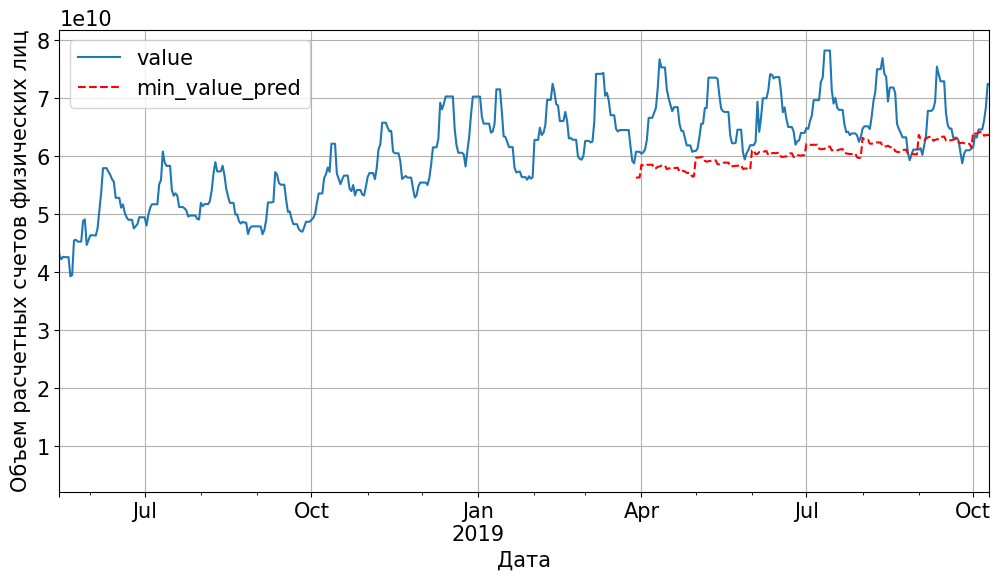

In [ ]:
ax = df_with_currency['value'].plot(figsize=(12,6))
pred_df_with_currency.plot(style='r--', ax=ax);
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");
ax.set_xlim(pd.Timestamp('2018-05-15'), max(df_with_currency.index))

# Лин регрессия 

Попробуем наконец линейную регрессию и градиентный бустинг

In [4]:
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [5]:
columns=['Date', 'value']
dt = pd.read_csv('data_1.csv', 
                 parse_dates=['Date'], 
                 dayfirst=True, 
                 header=None, 
                 names=columns)

dt = dt.set_index('Date')
dt = dt.sort_index()

Извлечем фичи из дат

In [6]:
train_size = int(0.9 * len(dt))
train_size
data_train = dt[:train_size]
data_test  = dt[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2013-12-30 00:00:00 --- 2019-03-18 00:00:00  (n=1899)
Test dates  : 2019-03-19 00:00:00 --- 2019-12-09 00:00:00  (n=212)


In [7]:
def create_features(dataset1, label=None):
    """
    Creates time series features from datetime index
    """
    dataset1.loc[:, 'date'] = dataset1.index
    dataset1.loc[:, 'dayofweek'] = dataset1['date'].dt.dayofweek
    dataset1.loc[:, 'quarter'] = dataset1['date'].dt.quarter
    dataset1.loc[:, 'month'] = dataset1['date'].dt.month
    dataset1.loc[:, 'year'] = dataset1['date'].dt.year
    dataset1.loc[:, 'dayofyear'] = dataset1['date'].dt.dayofyear
    dataset1.loc[:, 'dayofmonth'] = dataset1['date'].dt.day
    dataset1.loc[:, 'weekofyear'] = dataset1['date'].dt.weekofyear
    
    X = dataset1[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dataset1[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [8]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,
2019-03-19,1,1,3,2019,78,19,12
2019-03-20,2,1,3,2019,79,20,12
2019-03-21,3,1,3,2019,80,21,12
2019-03-22,4,1,3,2019,81,22,12
2019-03-23,5,1,3,2019,82,23,12
...,...,...,...,...,...,...,...
2019-12-05,3,4,12,2019,339,5,49
2019-12-06,4,4,12,2019,340,6,49
2019-12-07,5,4,12,2019,341,7,49


In [9]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_
sorted(list(zip(X_train.columns, importance)), 
       key=lambda x: abs(x[1]))

[('weekofyear', -54766036.211330056),
 ('dayofweek', 105134380.62204275),
 ('quarter', -209591103.1959647),
 ('dayofmonth', 922115192.9580677),
 ('dayofyear', -941436716.310718),
 ('year', 9943552416.505005),
 ('month', 29745663299.969315)]

In [10]:
pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,29745663299.970001
3,year,9943552416.510000
5,dayofmonth,922115192.960000
0,dayofweek,105134380.620000
6,weekofyear,-54766036.210000
1,quarter,-209591103.200000
4,dayofyear,-941436716.310000


In [11]:
y_predict = model.predict(X_test)

In [12]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 7.079502839174151e+19
Root Mean Squared Error: 8413978154.936077
Mean Absolute Error: 7416085403.630952
R2 -2.2085725961613925


In [13]:
for_sub = pd.DataFrame(model.predict(X_test), index=X_test.index)
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

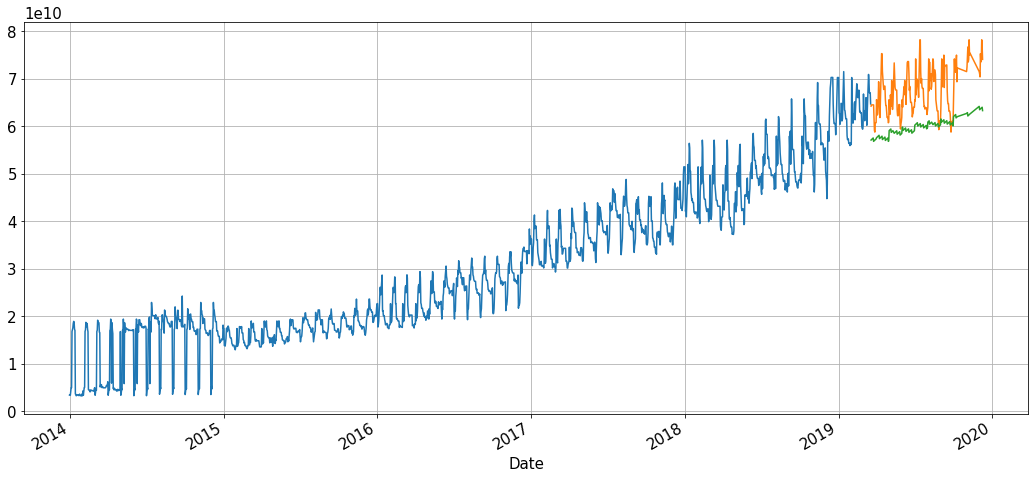

In [14]:
data_train['value'].plot()
data_test['value'].plot()
for_sub['value_pred'].plot()

# Вывод

В ходе проведения анализа вреиенных рядов физ счет, я рассмотрел 9 моделейБ конечно они далеки от идеала, в жизни бывают разные случаи. Заметил, что  счет увеличивается к середине месяца, затем падает в течение 10-15 дней и снова начинает расти. В некоторых точках графика наблюдается небольшое проседание ниже уровня предыдущего пика. Общая тенденция направлена на увеличение. Так же из всех модолей лучше всего сработала LSTM. В отличие от других алгоритмов машинного обучения, рекуррентные нейронные сети с долгой кратковременной памятью (в англоязычной терминологии LSTM) способны автоматически выявлять признаки из временных последовательностей, обрабатывать многомерные данные, а также выводить последовательности переменной длины, благодаря чему их можно использовать для интервального прогнозирования. Рассмотрим же минимальные объемы физ счетов, полученные спомощью этой модели..

In [ ]:
sub = pd.DataFrame(model.predict(testX), index=df_testY.index)
sub = sub.rename({0:'value_pred'}, axis=1)

sub 


2/2 [==============================] - 0s 5ms/step


,value_pred
Date,
2019-01-13,0.833252
2019-01-20,0.777122
2019-01-27,0.697368
2019-02-03,0.725106
2019-02-10,0.821494
2019-02-17,0.842053
2019-02-24,0.789371
2019-03-03,0.750274
2019-03-10,0.855342


In [ ]:
df_trainY = df_trainY.rename({0:'value'}, axis=1)
df_testY = df_testY.rename({0:'value'}, axis=1)
dfp=pd.concat([sub, df_testY['value']], axis=1)


Расчитаем минимумы за промежуток 1, 2, 3, 6 и 12 месецев

In [ ]:
dfp_min_m = sub .groupby(pd.Grouper(axis=0, freq='m')).min()
dfp_min_m


,value_pred
Date,
2019-01-31,0.697368
2019-02-28,0.725106
2019-03-31,0.749426
2019-04-30,0.779804
2019-05-31,0.771538
2019-06-30,0.751327
2019-07-31,0.790742
2019-08-31,0.791216
2019-09-30,0.746475


In [ ]:
dfp_min_m.mean()

value_pred    0.755889
dtype: float32

In [ ]:
dfp_min_2m = sub .groupby(pd.Grouper(axis=0, freq='2m')).min()
dfp_min_2m

,value_pred
Date,
2019-01-31,0.697368
2019-03-31,0.725106
2019-05-31,0.771538
2019-07-31,0.751327
2019-09-30,0.746475


In [ ]:
dfp_min_2m.mean()

value_pred    0.738363
dtype: float32

In [ ]:
dfp_min_3m = sub .groupby(pd.Grouper(axis=0, freq='3m')).min()
dfp_min_3m

,value_pred
Date,
2019-01-31,0.697368
2019-04-30,0.725106
2019-07-31,0.751327
2019-10-31,0.746475


In [ ]:
dfp_min_3m.mean()

value_pred    0.730069
dtype: float32

In [ ]:
dfp_min_6m = sub .groupby(pd.Grouper(axis=0, freq='6m')).min()
dfp_min_6m

,value_pred
Date,
2019-01-31,0.697368
2019-07-31,0.725106
2020-01-31,0.746475


In [ ]:
dfp_min_6m.mean()

value_pred    0.722983
dtype: float32

In [ ]:
dfp_min_12m = sub .groupby(pd.Grouper(axis=0, freq='12m')).min()
dfp_min_12m

,value_pred
Date,
2019-01-31,0.697368
2020-01-31,0.725106


In [ ]:
dfp_min_12m.mean()

value_pred    0.711237
dtype: float32

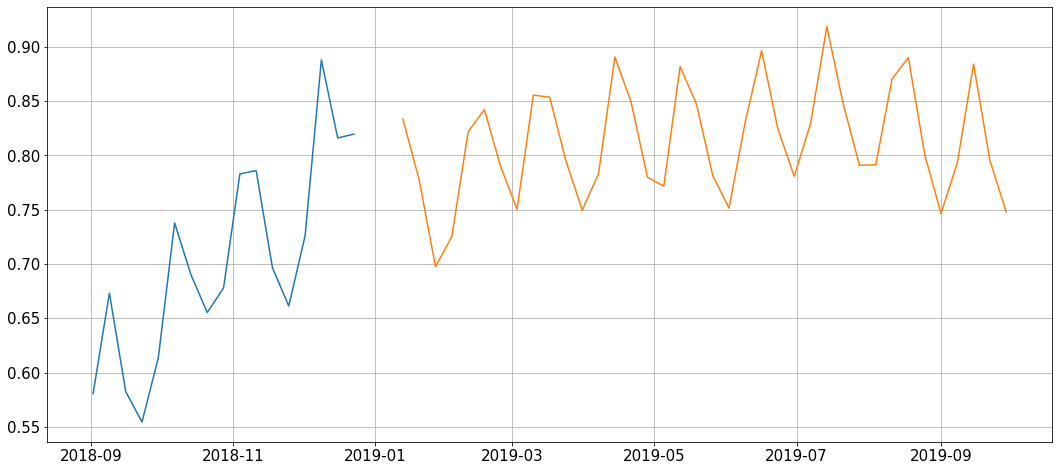

In [ ]:

plt.plot(df_trainY["09-2018":].index, df_trainY["09-2018":].values)
plt.plot(df_testY.index, testPredict,label='pred' )


В общем и целом скажу, что мне понравилось работать с временными рядами и при бОльшем количесвтве данных о физ лицах и о происходящей экономической ситуации, а также при бОльшем количестве моих знаний и умений в аналитике данных результат мог получиться гораздо лучше...
